# Differential Analysis of Ribosome Pausing.
This section will cover how to determine if the difference between our two datasets induces rate limiting pauses during translation elongation. First, the count arrays from the last section will be loaded into a Jupyter notebook and filtered so that only transcripts with sufficient length and read coverage are analyzed. Then, LOESS smoothing will be performed on the filtered count arrays and the cumulative distributions of the smoothed count arrays will be calculated. These cumulative distributions will be used to calculate the KS statistic for each gene. All of the genes will then be sorted into 3 separate bins based on whether they have low, medium, or high KS statistics. The fold enrichment of genes within each bin is then calculated. Finally, Fisher’s exact test will be used to determine if the observed enrichment of the target genes in various KS bins is statistically significant.

In [1]:
# Let the program know where to find your tools file.
import sys, os
sys.path.append(os.path.join(os.path.realpath(".."), "Tools"))

### Step 26
Load in all of the necessary Python packages. 

In [2]:
import numpy as np
import pandas as pd
import utilities as utils
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from multiprocess import Pool

In [31]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Trsp_targets/"
counts_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/position_counts_seleno/"
condition1 = "Trspfl"
condition2 = "control"
samp_num = "1"
image_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/figures/"

### Step 27
Load in the count arrays for both datasets. 

In [24]:
data_cond1, names_cond1 = utils.load_count_positions(counts_path + condition1 + "_" + samp_num + "_counts.csv")
data_cond2, names_cond2 = utils.load_count_positions(counts_path + condition2 + "_" + samp_num + "_counts.csv")

### Step 28
Smooth out the count arrays using LOESS smoothing and calculate the cumulative read distributions. The get_smoothed_vector function from the utilities.py file is set up to perform Loess smoothing with a window size equal to 5% of the transcript length and calculates the cumulative read distribution. This step can take some time so it is recommended to use the multiprocess’ Pool() function to complete this using multiple cores. 

In [25]:
max_pool = 8

with Pool(max_pool) as p:
    pool_cond2, pool_cond1 = list(
            p.imap(utils.get_smoothed_vector,
                   data_cond2)
        ), list(
            p.imap(utils.get_smoothed_vector,
                    data_cond1)
        )

### Step 29
For each gene in both datasets, calculate the KS-statistic as the maximum distance between their smoothed cumulative distributions and then save this KS-statistic as a list.  

In [26]:
ks_list = []
len_list = []
for tr_m, tr_c, index in zip(data_cond1, data_cond2, list(range(len(data_cond1)))):
    smoothed_vec_m, cumul_m = pool_cond1[index]
    smoothed_vec_c, cumul_c = pool_cond2[index]
    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))

### Step 30
Combine the lists for the gene IDs, gene lengths, and KS statistics into a pandas dataframe using the Pandas’ DataFrame function and rename the columns of the dataframe to something more suitable. 

In [27]:
ks_table = pd.DataFrame(list(zip(names_cond1, ks_list, len_list)))
ks_table.columns = ["gene_ID", "ks_stat", "gene_length"]

### Step 31
Load up a table containing a list of names for the genes affected by the differing conditions between our 2 datasets. The affected genes will be referred to as target genes or targets.

In [32]:
target_table = pd.read_csv(target_path + "Selenoprotein_table.csv", names = ["gene_ID"])

### Step 32
Merge the table of KS statistics and the table of target gene names into a new table using Pandas’ merge function. This new table will have an indicator column that shows if one of the target genes matched to one of the genes in the table of KS statistics. Then, sort the new table from lowest K-S statistic to highest K-S statistic to help with the plotting in later steps. 

In [33]:
temp_df = pd.merge(ks_table, target_table, how="left", on="gene_ID", indicator = True)

temp_df = temp_df.sort_values(by = "ks_stat")
temp_df = temp_df.reset_index(drop=True)

### Step 33
Clean up your new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name. 

In [34]:
temp_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

### Step 34
Use the indicator column created in step 32 to create 2 subsets of our table of KS statistics; one that only includes genes which matched with our target genes and one that only includes genes which did not match with our target genes.

In [35]:
targets = temp_df[temp_df._merge == "both"]

non_targets = temp_df[temp_df._merge == "left_only"]

### Step 35
Use matplotlib’s plot and violinplot functions to create plots which visualize the KS statistic for all of the target and non-target genes. 

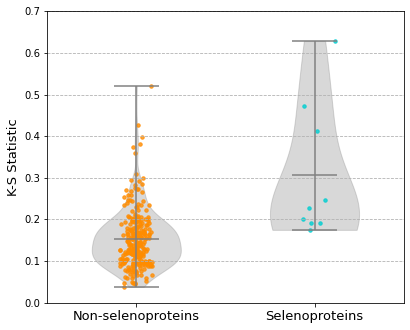

In [36]:
# Creating axes objects
fig = figure(figsize = (5.5,4.5))
ax = fig.add_axes([0,0,.9,.9])

# Adding violin plots
violin_parts = ax.violinplot([non_targets.ks_stat,targets.ks_stat], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(non_targets.ks_stat))
ax.scatter(x, non_targets.ks_stat, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(targets.ks_stat))
ax.scatter(x, targets.ks_stat, s = 12,  color = "darkturquoise", alpha=0.8)

# Determining x and y axis limits
ax.set_xlim(0.5,2.5)
ax.set_ylim(0,0.7)

# Labelling the axes.
positions = (1,2)
labels = ("Non-selenoproteins", "Selenoproteins")
ax.set_xticks(positions, labels, fontsize = 13)
plt.ylabel("K-S Statistic", fontsize = 13)

# Creating grid lines
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

fig.savefig(image_path + "violin_plot.pdf", bbox_inches = "tight")

### Step 36
Divide the data into low, medium, and high KS fractions and determine the fold enrichment of the target genes in each fraction using the determine enrichment function from utilities.py. The KS fractions in this example are set as all genes with a KS stat less than 0.15, All genes with a KS stat between 0.15 and 0.3, and all genes with a KS stat above 0.3. 

In [37]:
upper_ks = 0.3
N_cats = 2
enrich, sections = utils.determine_enrichment(targets, non_targets, upper_ks, N_cats)

### Step 37
Perform Fisher’s exact test to determine if the enrichment of targets in any of the K-S fractions is significant. The Fisher_exact_p_values function from utilities.py can be used to automatically calculate these P-values for each of the KS fractions. This function automatically performs three tests, so the outputted P-values should be adjusted using the benjamini hochberg method. This can be done using statsmodels' multipletests function. 

In [38]:
p_values = utils.Fisher_exact_p_values(targets, non_targets, sections)

adj_p_values = multipletests(p_values, method = "fdr_bh")[1]

### Step 38
Use matplotlib’s pyplot.bar function to create a series of barplots that show the fold enrichment of genes that are targets in each fraction. 

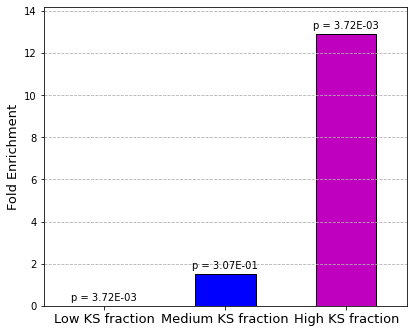

In [44]:
figure(figsize = (6.5,5.5))
bps = plt.bar([1,2,3],enrich, width = 0.5,
      tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"], 
      color = ["g", "b", "m"], edgecolor = "black")
plt.xticks(fontsize = 13)
plt.margins(0.1,0.1)
#plt.xlim(0.6,3.4)
#plt.ylim()
plt.ylabel("Fold Enrichment", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

for b, p in zip(bps, adj_p_values):
    height = b.get_height()
    plt.annotate("p = " + "{}".format("%.2E" % Decimal(p)),
      xy=(b.get_x() + b.get_width() / 2, height),
      xytext=(0, 3), textcoords="offset points",
      ha="center", va="bottom")
    
plt.savefig(image_path + "bar_plot.pdf")

### (Optional) 

After completing the analysis, one may wish to look at the count arrays and smoothed cumulative read distributions for individual genes of interest in order to observe the changes in read distribution. The following optional steps can be used to create these plots. 

### Step 39
Choose a gene of interest and then find its count vector from the both datasets. 

In [53]:
my_gene = "Selenop"
my_vec_cond1 = []
my_vec_cond2 = []
for tr_m, tr_c, name in zip(data_cond1, data_cond2, names_cond1):
    if name == my_gene:
        my_vec_cond1 = tr_m
        my_vec_cond2 = tr_c
if len(my_vec_cond1) == 0:
    raise ValueError("Gene name not found")

### Step 40
Create smoothed count arrays for the gene of interest.  

In [54]:
smoothed_vec_m, cumul_m = utils.get_smoothed_vector(my_vec_cond1+0.00000000001)
smoothed_vec_c, cumul_c = utils.get_smoothed_vector(my_vec_cond2+0.00000000001)

### Step 41
Use Matplotlib's bar function to create bar plots that show the raw count arrays for the gene of interest

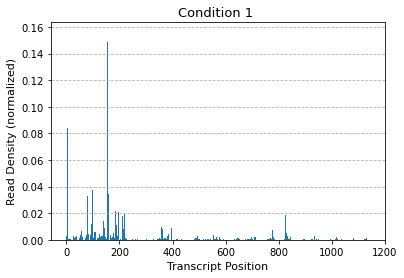

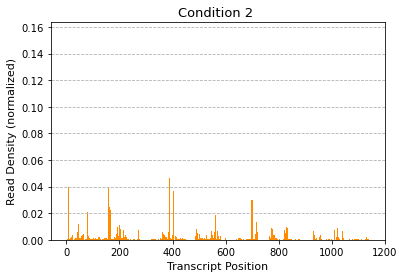

In [55]:
maxi = max([max(my_vec_cond1/sum(my_vec_cond1)), max(my_vec_cond2/sum(my_vec_cond2))])

plt.bar(list(range(len(my_vec_cond1))),my_vec_cond1/sum(my_vec_cond1), width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Condition 1 ", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + "cond_1_selenop_counts.pdf")
plt.show()

plt.bar(list(range(len(my_vec_cond1))), my_vec_cond2/sum(my_vec_cond2), color = "darkorange", width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Condition 2 ", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + "cond_2_selenop_counts.pdf")

### Step 42
Use Matplotlib's basic plot function to create line graphs that show the smoothed count arrays and the cumulative smoothed count arrays for the gene of interest. 

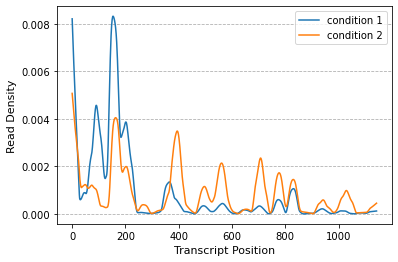

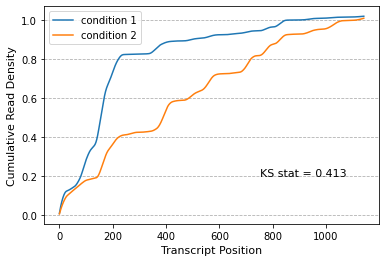

In [56]:
plt.plot(smoothed_vec_m, label = "condition 1")
plt.plot(smoothed_vec_c, label = "condition 2")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + "smoothed_selenop.pdf")
plt.show()

# Calculate the K-S statisticv from the cumulative distributions.
ks = max(abs(cumul_m - cumul_c))

plt.plot(cumul_m, label = "condition 1")
plt.plot(cumul_c, label = "condition 2")
plt.text(len(cumul_c)*0.66, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + "cumulative_selenop.pdf")